In [1]:
using DrWatson

@quickactivate

In [2]:
# so we can keep adding packages to the venv
"""using Pkg
Pkg.add("HDF5")"""

"using Pkg\nPkg.add(\"HDF5\")"

In [3]:
using HDF5
using Printf
using CairoMakie
using SparseArrays
using LinearAlgebra
using Statistics
using Distributed
"""# optimization tools
using Profile, ProfileSVG
using JET
using Cthulhu"""

"# optimization tools\nusing Profile, ProfileSVG\nusing JET\nusing Cthulhu"

In [4]:
using QuantumToolbox
using ITensors, ITensorMPS


"""# this is for compiling an itensor image so when we start it does not take ages to 
# comile the pakages. This only needs to be run onces per kernel or when you update the packages
# to create the sys_itensor.so image

using PackageCompiler

ITensors.compile()

# To load the image in a jupyter notebook:
# using IJulia
# installkernel("julia_ITensors","--sysimage=~/.julia/sysimages/sys_itensors.so")
# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json
# "--sysimage ~/.julia/sysimages/sys_itensors.so"
"""

"# this is for compiling an itensor image so when we start it does not take ages to \n# comile the pakages. This only needs to be run onces per kernel or when you update the packages\n# to create the sys_itensor.so image\n\nusing PackageCompiler\n\nITensors.compile()\n\n# To load the image in a jupyter notebook:\n# using IJulia\n# installkernel(\"julia_ITensors\",\"--sysimage=~/.julia/sysimages/sys_itensors.so\")\n# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json\n# \"--sysimage ~/.julia/sysimages/sys_itensors.so\"\n"

# MPS Functions

In [13]:
function ITensors.op(::OpName"Kerr", ::SiteType"Boson", d::Int)
    # Define a custom operator for the Kerr  using Quantum toolbox
    a = destroy(d) 
    kerr_mat = a'*a'*a*a
    
  return to_dense(kerr_mat.data)
end

function entangement_S(ψ, b)
    # b: index where we do the bipartition
    psi = orthogonalize(ψ, b)
    # do the SVM
    U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    SvN = 0.0
    # Geth the schmidt coefficients
    for n=1:dim(S, 1)
        p = S[n,n]^2
        SvN -= p * log(p)
    end
    return SvN
end


function ask_where(intervals)
    # decide where to project the staet when there is a jump, each element in intervals is associated to
    # a jump operator
    r2 = rand()
    dummy = 0
    j = 1
    found_site = -1
    while dummy == 0
        if r2<sum(intervals[1:j])
            dummy = 1
            found_site = j
        else 
            j = j+1
        end
    end
    return found_site
end

function build_TEBD(L, Ω, K ,J, Fd, Δτ, Nh, gammas::Vector{Float64})
    #  build site indices
    s = siteinds("Boson", L; dim=Nh, conserve_qns=false)
    # build the time evol gates for TEBD
    gates = ITensor[]
    # for the first site 
    s1 = s[1]
    s2 = s[2]
    h0 = -Ω*op("n",s1)*op("Id",s2) + 0.5*K*op("Kerr",s1)*op("Id",s2) + Fd*(op("adag",s1) + op("a",s1))*op("Id",s2)
    
    heff = - 0.5*im*gammas[1]*op("Id",s1)*op("n",s2)
    hj = h0 +  heff
    Gj = exp(-im * Δτ/2 * hj)
    push!(gates, Gj)

    for j in 2:(L)
        s1 = s[j]
        s2 = s[j-1] 

        h0 = -Ω*op("n",s1)*op("Id",s2) + 0.5*K*op("Kerr",s1)*op("Id",s2) - J*(op("adag",s1)*op("a",s2) + op("adag",s2)*op("a",s1))

        heff = - 0.5*im * gammas[j]*op("n",s1)*op("Id",s2)
        hj = h0 +  heff
        # troterized gate
        Gj = exp(-im * Δτ/2 * hj)
        push!(gates, Gj)
    end

    # The reverse gates for second order accuracy
    append!(gates, reverse(gates))

    return s, gates

end


function compute_trajectory_tebd(s::Vector{Index{Int64}}, gates::Vector{ITensor}, L::Int64, J::Float64,
                             Δτ::Float64, ttotal::Float64, Nh::Int64, gammas::Vector{Float64}, cutoff::Float64)
    # bettwe to put it in a function to avoid the global julia scope
    """ 
    s = indices for truncation
    Gj = TEBD circuit for one step
    L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff
    Nh = local hilbert space dimension
    gamma = dissipation
    """

    n_tsteps = round(Int64, ttotal/Δτ)+1
    occupations = Vector{Vector{Float64}}(undef, n_tsteps)
    corr_matrices = Vector{Matrix{ComplexF64}}(undef, n_tsteps)
    entropies = zeros(n_tsteps)
    bond_dimensions = zeros(Int, n_tsteps)
    # for the wigner distributions
    a_operators = Vector{Vector{ComplexF64}}(undef, n_tsteps)

    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "0"
    psi = MPS(s, state_list)
    psi_cand = copy(psi) # candidate for new state}

    dummy_counter = 1

    for t in 0.0:Δτ:ttotal
        # keep track of the occupations at each time step

        occ = ITensorMPS.expect(psi,"N")        
        # entanglement entropy between two equal sized parts of the chain
        Svn = entangement_S(psi, round(Int64, L/2))
        occupations[dummy_counter] = occ
        corr_matrices[dummy_counter] = correlation_matrix(psi,"adag","a")
        entropies[dummy_counter] = Svn
        bond_dimensions[dummy_counter] = ITensorMPS.maxlinkdim(psi)
        a_operators[dummy_counter] = ITensorMPS.expect(psi,"a") 

        t≈ttotal && break

        # metropolis step
        psi_cand = apply(gates, psi; cutoff) # candidate for new state}
        norm = inner(psi_cand',psi_cand)
        proba_act = real(1 - norm)
        r1 = rand()
        if r1 > proba_act
            # here no jump so we accept the state
            psi = psi_cand/norm
        else
            # jump, so choose which state we project to
            δp_list = [gammas[i]*ITensorMPS.expect(psi,"N",sites=i) for i in 1:L]  
            normalize!(δp_list)
            jump_site = ask_where(δp_list)
            jump_op = sqrt(gammas[jump_site])*op("a",s[jump_site]);
            psi = apply(jump_op , psi)
            normalize!(psi)
        end

        dummy_counter+=1
    end

    return occupations, entropies, bond_dimensions, corr_matrices, a_operators
end

function compute_trajectory_tdvp(s::Vector{Index{Int64}}, gates, L::Int64, J::Float64,
                             Δτ::Float64, ttotal::Float64, Nh::Int64, gammas::Vector{Float64}, cutoff::Float64)
    # bettwe to put it in a function to avoid the global julia scope
    """ 
    s = indices for truncation
    Gj = TEBD circuit for one step
    L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff
    Nh = local hilbert space dimension
    gamma = dissipation
    """

    n_tsteps = round(Int64, ttotal/Δτ)+1
    occupations = Vector{Vector{Float64}}(undef, n_tsteps)
    corr_matrices = Vector{Matrix{ComplexF64}}(undef, n_tsteps)
    entropies = zeros(n_tsteps)
    bond_dimensions = zeros(Int, n_tsteps)
    # for the wigner distributions
    a_operators = Vector{Vector{ComplexF64}}(undef, n_tsteps)

    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "0"
    psi = MPS(s, state_list)
    psi_cand = copy(psi) # candidate for new state}

    dummy_counter = 1

    for t in 0.0:Δτ:ttotal
        # keep track of the occupations at each time step

        occ = ITensorMPS.expect(psi,"N")        
        # entanglement entropy between two equal sized parts of the chain
        Svn = entangement_S(psi, round(Int64, L/2))
        occupations[dummy_counter] = occ
        corr_matrices[dummy_counter] = correlation_matrix(psi,"adag","a")
        entropies[dummy_counter] = Svn
        bond_dimensions[dummy_counter] = ITensorMPS.maxlinkdim(psi)
        a_operators[dummy_counter] = ITensorMPS.expect(psi,"a") 

        t≈ttotal && break

        # metropolis step tdvp(H,tmax,psi0,time_step=0.01, cutoff=cutoff, normalize=true, reverse_step=false);
        psi_cand = tdvp(gates,Δτ,psi,time_step=Δτ, nsweeps=1 ,cutoff=cutoff, normalize=false, reverse_step=false)
        norm = inner(psi_cand',psi_cand)
        proba_act = real(1 - norm)
        r1 = rand()

        if r1 > proba_act
            # here no jump so we accept the state
            psi = psi_cand/norm
        else
            # jump, so choose which state we project to
            δp_list = [gammas[i]*ITensorMPS.expect(psi,"N",sites=i) for i in 1:L]  
            normalize!(δp_list)
            jump_site = ask_where(δp_list)
            jump_op = sqrt(gammas[jump_site])*op("a",s[jump_site]);
            psi = apply(jump_op , psi)
            normalize!(psi)
        end

        dummy_counter+=1
    end

    return occupations, entropies, bond_dimensions, corr_matrices, a_operators
end

function build_tdvp(L, Ω, K ,J, Fd, Nh, gammas::Vector{Float64})

    s = siteinds("Boson", L; dim=N, conserve_qns=false)
    # build the time evol gates for TEBD
    gates = ITensor[]

    h0 = OpSum()
    heff = OpSum()

    h0 += -Ω, "n", 1 
    h0 += 0.5*K, "Kerr", 1 
    h0 += Fd, "adag", 1 
    h0 += Fd, "a", 1 
    heff += - 0.5*im*gammas[1], "n", 1
    for j in 2:L
        # Bare Hamiltonian
        h0 += -Ω, "n", j 
        h0 += 0.5*K, "Kerr", j 
        h0 += Fd, "adag", j 
        h0 += Fd,"a", j 
        h0 += -J , "adag", j, "a", j-1
        h0 += -J, "adag", j-1 , "a", j
        # effective Hamiltonian
        heff += - 0.5*im*gammas[1], "n", j

    end

    hj = h0 +  heff
        # The reverse gates for second order accuracy
    return s, MPO(hj,s)
end

"""
let
    s_indices, gates = build_tdvp(L, ω, U, J, F, N, γ_list)
    @time occupations, Svns, bond_dim, correlation_matrix, a_operators = compute_trajectory_tdvp(s_indices, gates, L, J,tlist[2]-tlist[1], 10.0, N, γ_list,1*10^(-18))

end
"""
#
"""
γ_list = γ.*ones(L)

let
    s_indices, gates = build_TEBD(L, ω, U, J, F, tlist[2]-tlist[1], N, γ_list)
    @time occupations, Svns, bond_dim, correlation_matrix, a_operators = compute_trajectory_tebd(s_indices, gates, L, J,tlist[2]-tlist[1], 10.0, N, γ_list,1*10^(-18))
    #println(typeof(a_operators))
    println(a_operators)
end"""



"γ_list = γ.*ones(L)\n\nlet\n    s_indices, gates = build_TEBD(L, ω, U, J, F, tlist[2]-tlist[1], N, γ_list)\n    @time occupations, Svns, bond_dim, correlation_matrix, a_operators = compute_trajectory_tebd(s_indices, gates, L, J,tlist[2]-tlist[1], 10.0, N, γ_list,1*10^(-18))\n    #println(typeof(a_operators))\n    println(a_operators)\nend"

# Main

In [ ]:
N = 3 # local hilbert space dimension
L = 6 # size of the chain
ω = 2.5 # frequency of the harmonic oscillator
J = 2.0 # hopping
γ = 1.0 # damping rate
γ_list = γ.*ones(L)
U = 0.1 # Kerr non-linearity
F = 1.5 # Pump strength
maxt = 15.0 # maximum time
cutoff_exponent = -18
cutoff = 10.0^cutoff_exponent
N_trajectories = 100
Delta_t = 0.1
time_list = 0.0:Delta_t:maxt
γ_list = γ.*ones(L)
evol_type = "TEBD" # TDVP

"TEBD"

In [35]:
println(Threads.nthreads())


4


In [ ]:

occupation_ensemble = Vector{Matrix{Float64}}(undef, N_trajectories)
correlation_ensemble = Vector{Vector{Matrix{ComplexF64}}}(undef, N_trajectories)
entropy_ensemble = zeros(N_trajectories, length(time_list))
b_dims_ensemble = zeros(N_trajectories, length(time_list))
a_ensemble = Vector{Vector{Vector{ComplexF64}}}(undef, N_trajectories)

if evol_type == "TEBD"
    println("Doing TEBD...")
    s_indices, gates = build_TEBD(L, ω, U, J, F, Delta_t, N, γ_list)

    Threads.@threads for traj in 1:N_trajectories
        occupations, Svns, bond_dim, correlation_matrix, a_operators = compute_trajectory_tebd(s_indices, gates, L, J,
                                                                Delta_t, maxt, N, γ_list, cutoff);
        occupations = reduce(hcat, occupations);
        occupation_ensemble[traj] = occupations
        entropy_ensemble[traj, 1:end] = Svns
        b_dims_ensemble[traj, 1:end] = bond_dim
        correlation_ensemble[traj] = correlation_matrix
        a_ensemble[traj] = a_operators
    end
    
"""else
    println("Doing TDVP...")
    s_indices, gates = build_tdvp(L, ω, U, J, F, N, γ_list)
    Threads.@threads for traj in 1:N_trajectories
    occupations, Svns, bond_dim, correlation_matrix, a_operators = compute_trajectory_tdvp(s_indices, gates, L, J,Delta_t, maxt, N, γ_list,cutoff)

    occupations = reduce(hcat, occupations);
    occupation_ensemble[traj] = occupations
    entropy_ensemble[traj, 1:end] = Svns
    b_dims_ensemble[traj, 1:end] = bond_dim
    correlation_ensemble[traj] = correlation_matrix
    a_ensemble[traj] = a_operators
    end"""
    
end


Doing TEBD...


In [47]:

mean_traj = mean(occupation_ensemble)
mean_entropy = mean(entropy_ensemble,dims=1)[1,1:end]
mean_bond = mean(b_dims_ensemble,dims=1)[1,1:end]
tot_oc = sum(mean_traj, dims=1)[1:end]
mean_corr = mean(correlation_ensemble)
mean_a = mean(a_ensemble);


## Save data

In [48]:
str_file_name = @sprintf("../data/sims/benchmark/%s_N%i_L%i_om%.2f_J%.2f_gamma%.2f_kerr%.2f_drive%.2f_maxt%.2f_deltat%.2f_traj%i_cutexp%i.h5", evol_type,N,L,ω,J,γ,U,F,maxt,Delta_t, N_trajectories,cutoff_exponent)

param_dict = Dict("type"=>evol_type,"N"=>N, "L"=>L, "omega" =>ω,"J" =>J,"gamma"=>γ ,"U"=>U ,"F"=>F ,
                "maxt"=>maxt, "N_trajectories"=>N_trajectories, "cutoff"=>cutoff, "delta_t" =>Delta_t)


Dict{String, Any} with 12 entries:
  "N_trajectories" => 200
  "L"              => 6
  "cutoff"         => 1.0e-18
  "omega"          => 2.5
  "N"              => 3
  "delta_t"        => 0.1
  "maxt"           => 15.0
  "J"              => 2.0
  "U"              => 0.1
  "gamma"          => 1.0
  "type"           => "TEBD"
  "F"              => 1.5

In [50]:
# Save data

fid = h5open(str_file_name, "w")
    # write the metadata to its own group
    create_group(fid, "metadata")
    meta = fid["metadata"]
    for (k, v) in param_dict
            meta[k] = v  # save each entry under its key
    end
    # save the results
    res_g = create_group(fid, "results")
    res_g["occupations"] = mean_traj
    res_g["entropy_first_to_half"] = mean_entropy
    res_g["bond_dimension"] = mean_bond 
    # for the matrices we have to save them as a tensor where time is one of the indices
    res_g["twobody_correlation"] = cat(mean_corr...; dims=3)   

    size1 = length(a_ensemble)
    size2 = length(a_ensemble[1])
    size3 = length(a_ensemble[1][1])

    tn_ = Array{ComplexF64}(undef, size1, size2, size3);
    for i in 1:size1, j in 1:size2, k in 1:size3
        tn_[i, j, k] = a_ensemble[i][j][k]
    end

    res_g["annihilation_expectation"] = tn_     

close(fid)



## Quick Analysis

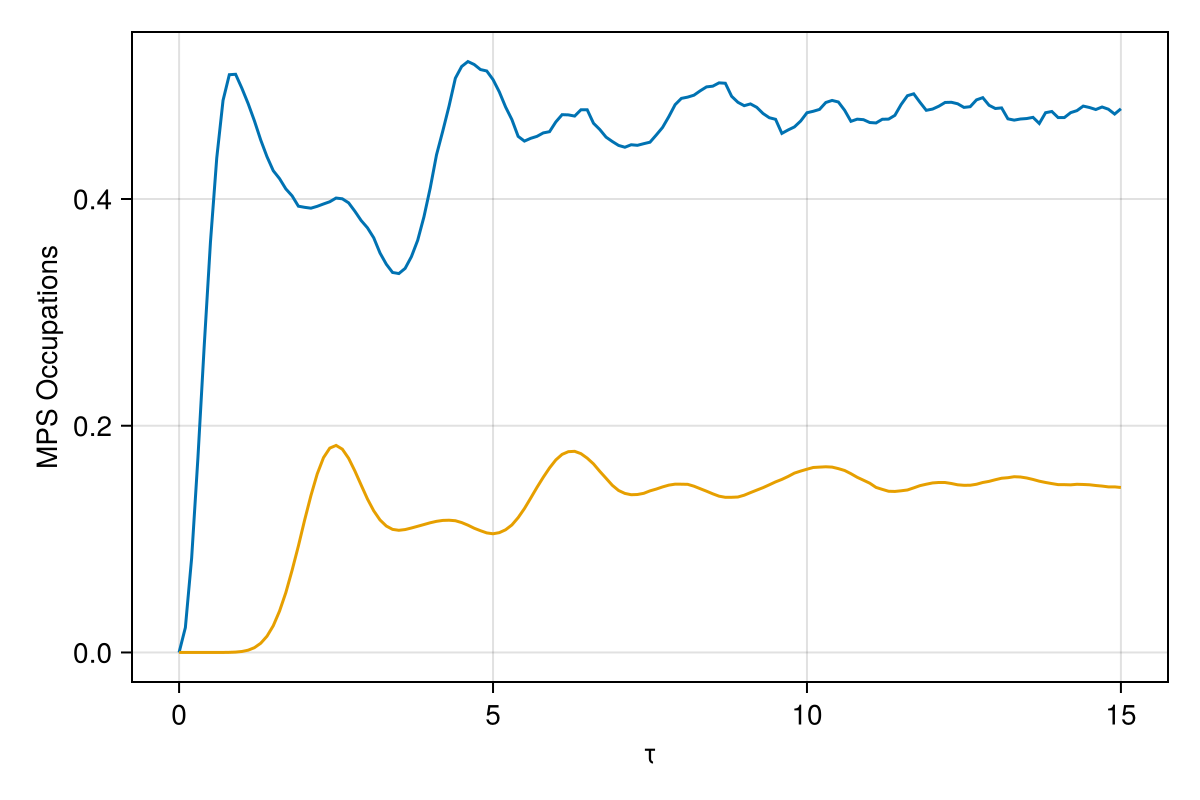

In [51]:
f = Figure(size = (600, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")

lines!(ax1, time_list, mean_traj[1,1:end])
lines!(ax1, time_list, mean_traj[end,1:end])


f

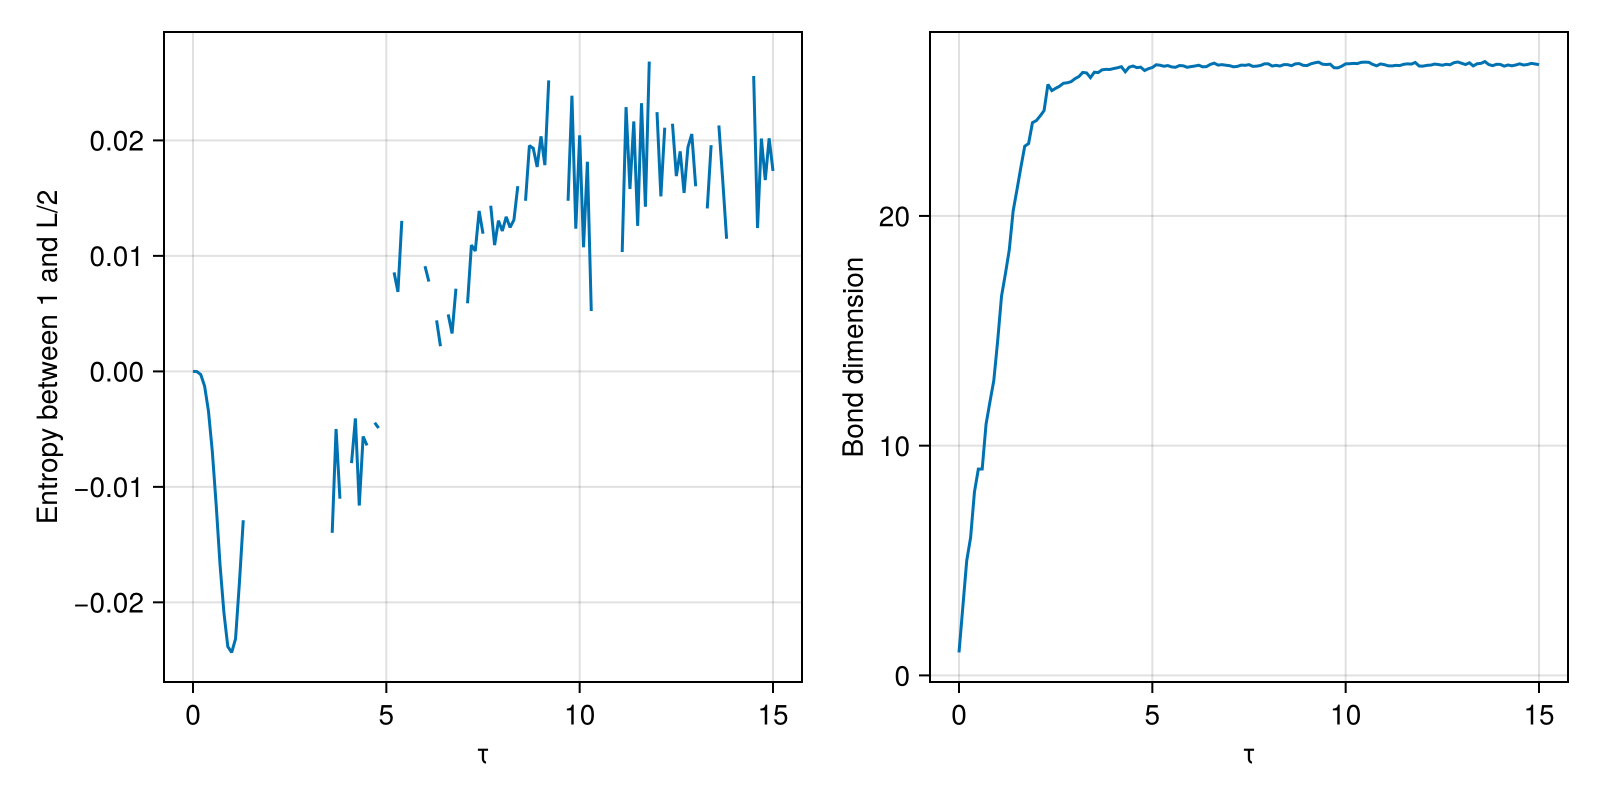

In [52]:
f= Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Entropy between 1 and L/2")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Bond dimension")


lines!(ax1, time_list, mean_entropy)
lines!(ax2, time_list, mean_bond)

f

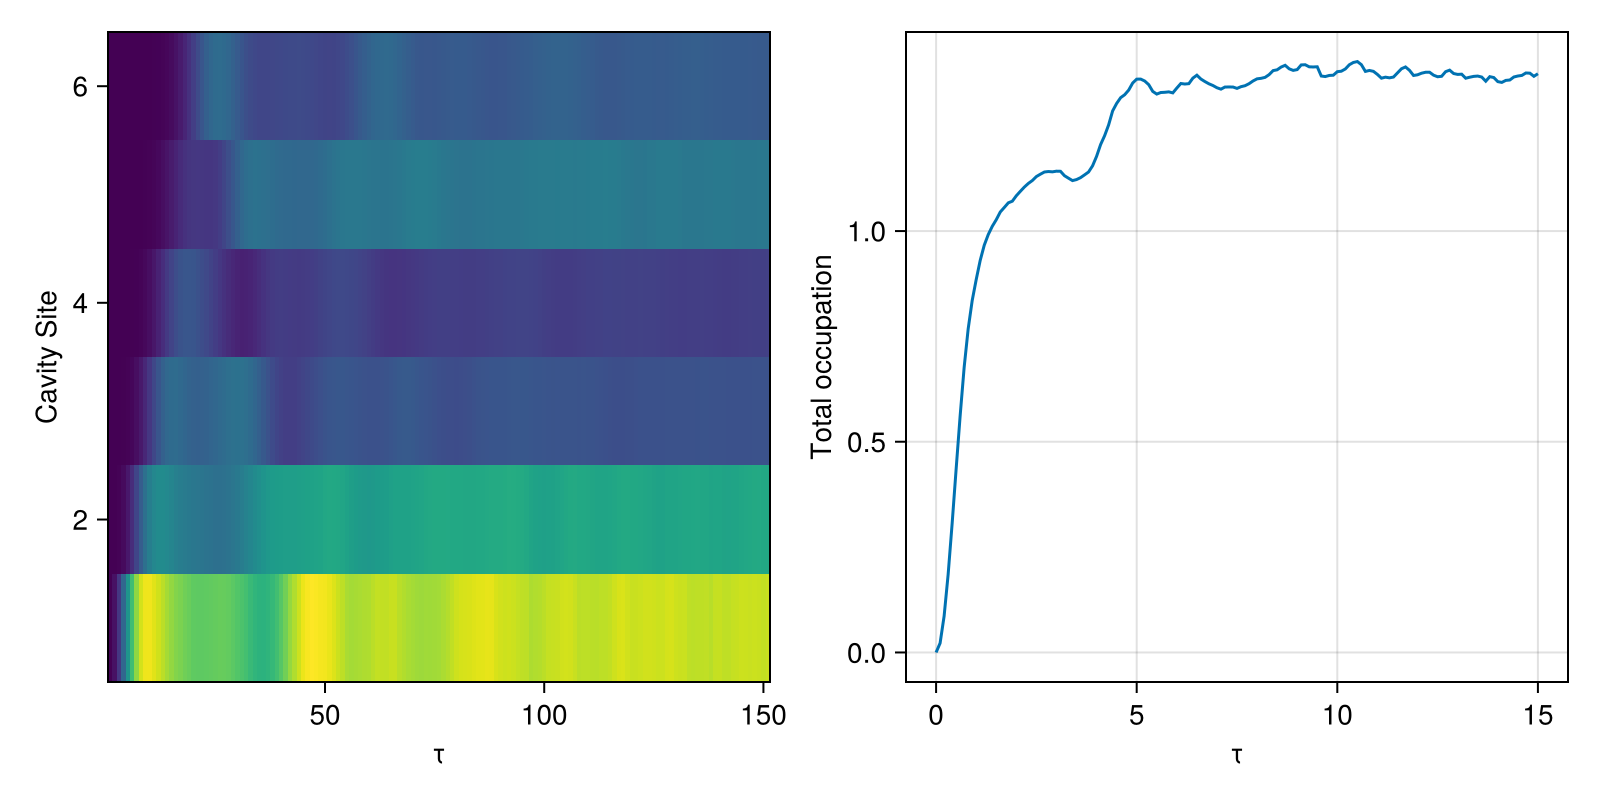

In [53]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Cavity Site")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Total occupation")

heatmap!(ax1, transpose(mean_traj))
lines!(ax2, time_list, tot_oc)

f 

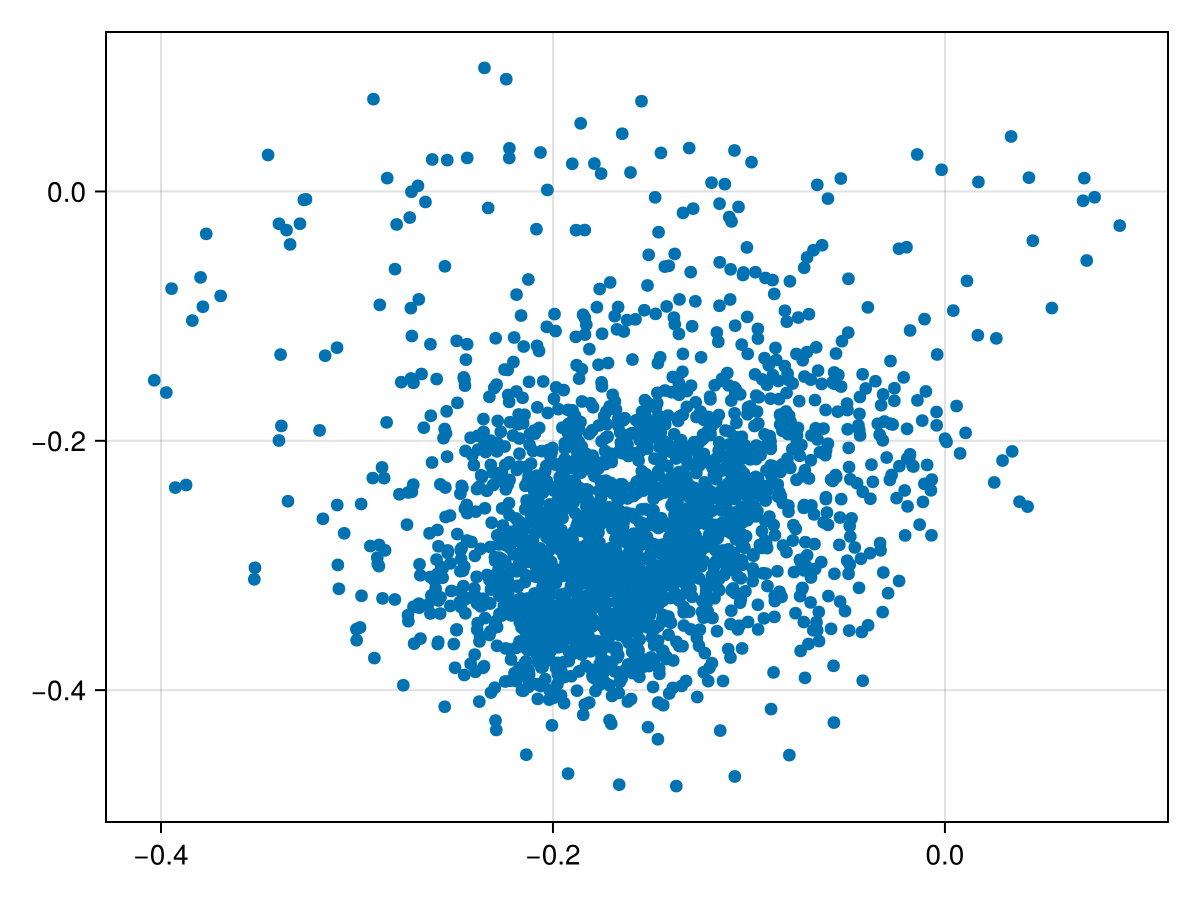

In [54]:
# grab the value of each configuration at a given lattice site ffor lonf times
a_first = []
a_middle = []
a_last = []

for traj in 1:N_trajectories
    for time_i in 0:10
        push!(a_first, a_ensemble[traj][end-time_i][1])
        push!(a_middle, a_ensemble[traj][end-time_i][round(Int64, L/2)])
        push!(a_last, a_ensemble[traj][end-time_i][end])
    end
end

scatter(real(a_middle), imag(a_middle))

In [55]:
# don0t forget the normalziattion factor
tindex = 10
Ct1 = mean_corr[tindex][1,1:end]/sqrt(mean_corr[tindex][1,1]*mean_corr[tindex][end,end])
Ctf = mean_corr[end][1,1:end]/sqrt(mean_corr[end][1,1]*mean_corr[end][end,end])


6-element Vector{ComplexF64}:
    1.8154164531410397 + 8.627115943050913e-18im
   -0.9216271170315442 + 1.0013925878767551im
 -0.004742073045869695 - 0.7768818667793927im
    0.6534638179114239 + 0.024381125365062744im
   -0.8444336846430306 + 0.5474517373797441im
    0.5831642147113508 - 0.5291319927627892im

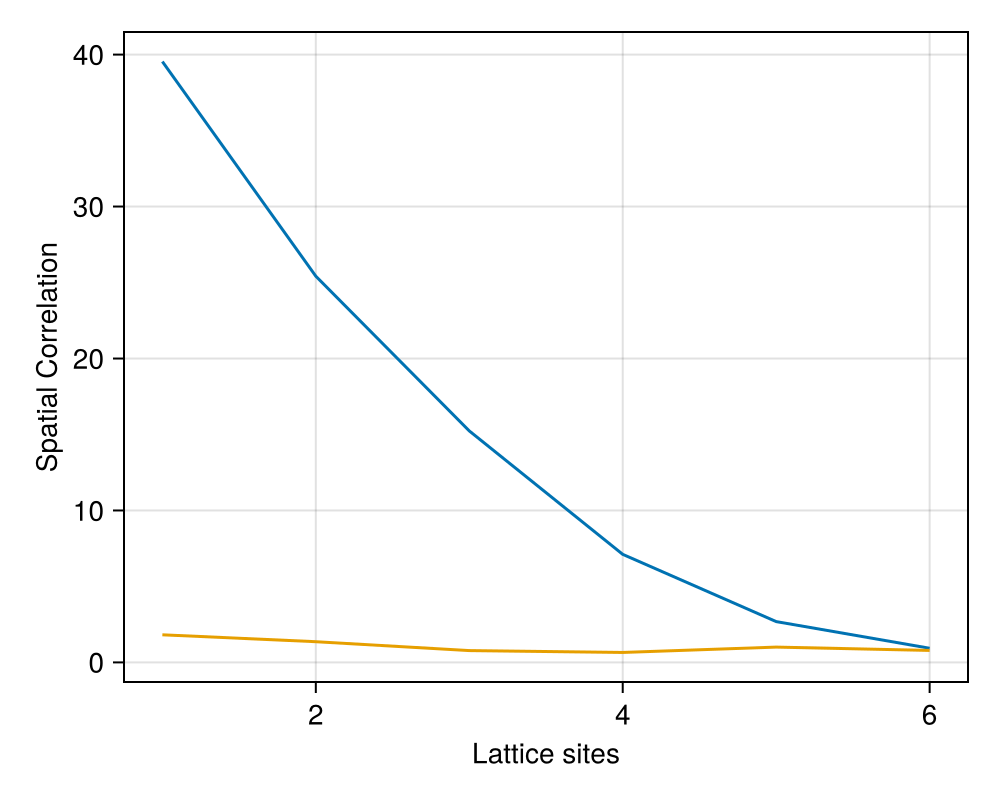

In [56]:
f = Figure(size = (500, 400))
ax1 = Axis(f[1, 1], xlabel="Lattice sites", ylabel="Spatial Correlation")

lines!(abs.(Ct1))
lines!(abs.(Ctf))

f